In [2]:
import pandas as pd
import spacy

In [3]:
# Charger les données
df = pd.read_json('reviews.jsonl', lines=True)
print("Aperçu des données initiales :")
print(df.head(20))

Aperçu des données initiales :
    rating                                              title  \
0        4                   No white background! It’s clear!   
1        5                Awesome!  Great price!  Works well!   
2        5                 Worked but took an hour to install   
3        4                                             Decent   
4        5                                           LOVE IT!   
5        5        Works Great with my IPhone 13 & Magna Case!   
6        5                       Great item! Easy to install!   
7        4                                         Four Stars   
8        5  It is a great value & protects the phone from ...   
9        5                         Good to have these around!   
10       5                                        These work!   
11       5                 Finally something I can Hang onto!   
12       5                               Great, great, great!   
13       5                                       Great valu

In [4]:
# Sélection des champs pertinents
df = df[['rating', 'title', 'text']]
print("\nDonnées avec champs sélectionnés :")
print(df.head())


Données avec champs sélectionnés :
   rating                                title  \
0       4     No white background! It’s clear!   
1       5  Awesome!  Great price!  Works well!   
2       5   Worked but took an hour to install   
3       4                               Decent   
4       5                             LOVE IT!   

                                                text  
0  I bought this bc I thought it had the nice whi...  
1  Perfect. How pissed am I that I recently paid ...  
2  Overall very happy with the end result. If you...  
3  Lasted about 9 months then the lock button bro...  
4  LOVE THIS CASE! Works better than my expensive...  


In [5]:
# Charger le modèle spaCy
nlp = spacy.load("en_core_web_sm")

In [6]:
# Fonction de prétraitement
def preprocess_text_spacy(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if (
            not token.is_stop  # Exclure les stop words
            and token.is_alpha  # Exclure les symboles et chiffres
            and len(token) > 2  # Exclure les mots courts
        ):
            tokens.append(token.lemma_)  # Lemmatisation (normalisation des mots, ex : "était" -> "être")
    return tokens

In [7]:
# Appliquer la fonction de prétraitement
df['processed_tokens'] = df['text'].apply(preprocess_text_spacy)
print("\nDonnées après prétraitement :")
print(df.head())


Données après prétraitement :
   rating                                title  \
0       4     No white background! It’s clear!   
1       5  Awesome!  Great price!  Works well!   
2       5   Worked but took an hour to install   
3       4                               Decent   
4       5                             LOVE IT!   

                                                text  \
0  I bought this bc I thought it had the nice whi...   
1  Perfect. How pissed am I that I recently paid ...   
2  Overall very happy with the end result. If you...   
3  Lasted about 9 months then the lock button bro...   
4  LOVE THIS CASE! Works better than my expensive...   

                                    processed_tokens  
0  [buy, think, nice, white, background, turn, cl...  
1  [perfect, pissed, recently, pay, fitbit, cable...  
2  [overall, happy, end, result, hate, puzzle, lo...  
3  [last, month, lock, button, break, decent, pro...  
4     [love, case, work, well, expensive, case, lol]  


In [ ]:
# Sauvegarder les données prétraitées si nécessaire
df.to_csv('processed_reviews.csv', index=False)
print("\nLes données prétraitées ont été sauvegardées dans 'processed_reviews.csv'.")


Les données prétraitées ont été sauvegardées dans 'processed_reviews.csv'.


In [9]:
#Étape 2 : Génération des embeddings

In [10]:
# Charger les données prétraitées
df = pd.read_csv('processed_reviews.csv')
documents = df['processed_tokens'].apply(eval)  # Convertir les chaînes de tokens en listes Python
documents = [" ".join(tokens) for tokens in documents]  # Convertir les listes en chaînes
print(f"Nombre de documents : {len(documents)}")

Nombre de documents : 1000


In [11]:
#2. Génération des embeddings 
#Option  : Utiliser TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Configurer et appliquer TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiter à 5000 caractéristiques
tfidf_embeddings = tfidf_vectorizer.fit_transform(documents)
print(f"Taille de la matrice TF-IDF : {tfidf_embeddings.shape}")
print("Exemple d'embedding TF-IDF :")
print(tfidf_embeddings.toarray()[:2])


Taille de la matrice TF-IDF : (1000, 2592)
Exemple d'embedding TF-IDF :
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
# 3. Clustering
#Option : DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Appliquer DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10, metric='cosine')  # 'cosine' est recommandé pour les données textuelles
dbscan_labels = dbscan.fit_predict(tfidf_embeddings)

# Nombre de clusters identifiés (ignorer le bruit, label = -1)
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Nombre de clusters identifiés : {num_clusters}")

Nombre de clusters identifiés : 4


In [13]:
from sklearn.metrics import silhouette_score

# Filtrer les points de bruit (-1)
valid_points = dbscan_labels != -1
if valid_points.any():  # Vérifie si des clusters valides existent
    silhouette_avg = silhouette_score(
        tfidf_embeddings[valid_points], dbscan_labels[valid_points], metric='cosine'
    )
    print(f"\nScore de silhouette moyen (sans le bruit) : {silhouette_avg:.3f}")
else:
    print("\nImpossible de calculer le score de silhouette : aucun cluster valide.")


Score de silhouette moyen (sans le bruit) : 0.360


In [14]:
#4. Analyse des clusters : 

from collections import defaultdict

# Associer les documents à leurs clusters
clusters = defaultdict(list)
for i, label in enumerate(dbscan_labels):
    clusters[label].append(documents[i])

# Analyser les mots-clés dans chaque cluster
from sklearn.feature_extraction.text import CountVectorizer

for cluster_id, docs in clusters.items():
    print(f"\nCluster {cluster_id} :")
    vectorizer = CountVectorizer(max_features=20)  # Limiter à 10 mots-clés
    word_counts = vectorizer.fit_transform(docs)
    words = vectorizer.get_feature_names_out()
    freqs = word_counts.sum(axis=0).A1
    keywords = sorted(zip(words, freqs), key=lambda x: -x[1])
    print("Mots-clés les plus fréquents :", keywords)



Cluster -1 :
Mots-clés les plus fréquents : [('phone', np.int64(757)), ('case', np.int64(576)), ('work', np.int64(259)), ('great', np.int64(222)), ('like', np.int64(220)), ('good', np.int64(212)), ('fit', np.int64(208)), ('charge', np.int64(199)), ('screen', np.int64(184)), ('use', np.int64(176)), ('love', np.int64(170)), ('easy', np.int64(154)), ('look', np.int64(148)), ('time', np.int64(137)), ('need', np.int64(119)), ('get', np.int64(117)), ('iphone', np.int64(117)), ('cover', np.int64(111)), ('nice', np.int64(108)), ('new', np.int64(100))]

Cluster 0 :
Mots-clés les plus fréquents : [('great', np.int64(34)), ('work', np.int64(17)), ('fit', np.int64(8)), ('case', np.int64(7)), ('look', np.int64(5)), ('phone', np.int64(4)), ('color', np.int64(3)), ('feel', np.int64(2)), ('product', np.int64(2)), ('protect', np.int64(2)), ('car', np.int64(1)), ('charge', np.int64(1)), ('cool', np.int64(1)), ('cute', np.int64(1)), ('design', np.int64(1)), ('durable', np.int64(1)), ('fast', np.int64(1)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Étape 1 : Regrouper les documents par cluster
cluster_docs = {cluster_id: " ".join(docs) for cluster_id, docs in clusters.items()}

# Étape 2 : Préparer les données pour c-TFIDF
# On crée un DataFrame où chaque ligne représente un "document" correspondant à un cluster
df_clusters = pd.DataFrame(list(cluster_docs.items()), columns=["cluster_id", "text"])

# Étape 3 : Calculer le c-TFIDF
vectorizer = TfidfVectorizer(max_features=20)  # Limiter le nombre de mots-clés
tfidf_matrix = vectorizer.fit_transform(df_clusters["text"])
terms = vectorizer.get_feature_names_out()

# Étape 4 : Afficher les mots-clés par cluster triés par score
for i, cluster_id in enumerate(df_clusters["cluster_id"]):
    print(f"\nCluster {cluster_id} :")
    scores = tfidf_matrix[i].toarray().flatten()
    # Trier directement les mots par leur score
    sorted_keywords = sorted(zip(terms, scores), key=lambda x: -x[1])  # Trier par score décroissant
    sorted_keywords = [(term, round(score, 3)) for term, score in sorted_keywords if score > 0]  # Garder les scores positifs
    print("Mots-clés les plus caractéristiques :", sorted_keywords)



Cluster -1 :
Mots-clés les plus caractéristiques : [('phone', np.float64(0.542)), ('case', np.float64(0.488)), ('screen', np.float64(0.277)), ('like', np.float64(0.222)), ('work', np.float64(0.219)), ('use', np.float64(0.213)), ('charge', np.float64(0.169)), ('great', np.float64(0.159)), ('good', np.float64(0.152)), ('fit', np.float64(0.149)), ('get', np.float64(0.142)), ('time', np.float64(0.138)), ('cover', np.float64(0.135)), ('easy', np.float64(0.13)), ('look', np.float64(0.125)), ('love', np.float64(0.122)), ('need', np.float64(0.12)), ('iphone', np.float64(0.118)), ('review', np.float64(0.102)), ('nice', np.float64(0.077))]

Cluster 0 :
Mots-clés les plus caractéristiques : [('great', np.float64(0.812)), ('work', np.float64(0.48)), ('case', np.float64(0.198)), ('fit', np.float64(0.191)), ('look', np.float64(0.141)), ('phone', np.float64(0.096)), ('iphone', np.float64(0.034)), ('like', np.float64(0.034)), ('need', np.float64(0.034)), ('charge', np.float64(0.028)), ('good', np.flo

### Nuage de Points des Mots les Plus Répétés

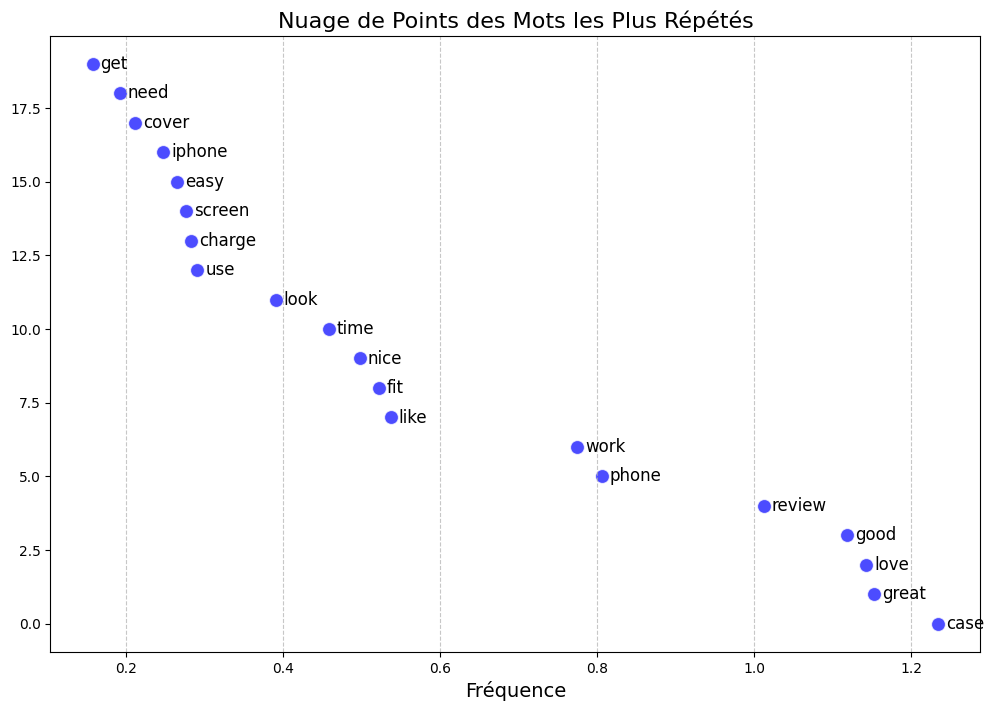

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 1 : Calculer les fréquences globales des mots
from collections import Counter

global_keywords = Counter()
for i in range(tfidf_matrix.shape[0]):
    scores = tfidf_matrix[i].toarray().flatten()
    for term, score in zip(terms, scores):
        global_keywords[term] += score

# Extraire les mots et leurs scores
most_common = global_keywords.most_common(20)  # Prendre les 20 mots les plus fréquents
words, frequencies = zip(*most_common)

# Étape 2 : Création du nuage de points
plt.figure(figsize=(12, 8))
sns.scatterplot(x=frequencies, y=range(len(words)), s=100, color="blue", alpha=0.7)

# Ajouter les mots en tant qu'annotations
for i, word in enumerate(words):
    plt.text(frequencies[i] + 0.01, i, word, fontsize=12, va='center')

# Configurer le graphique
plt.title("Nuage de Points des Mots les Plus Répétés", fontsize=16)
plt.xlabel("Fréquence", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### Distribution des Ratings

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='rating', data=df, palette="viridis")
plt.title("Distribution des Ratings")
plt.xlabel("Rating")
plt.ylabel("Nombre de commentaires")
plt.show()


C:\Users\ghebr\AppData\Local\Temp\ipykernel_21416\1340696155.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette="viridis")


### Nuage de Mots par Cluster

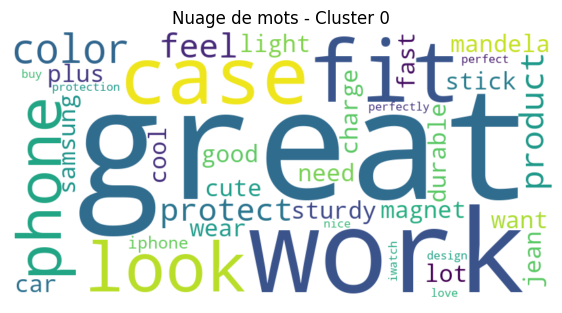

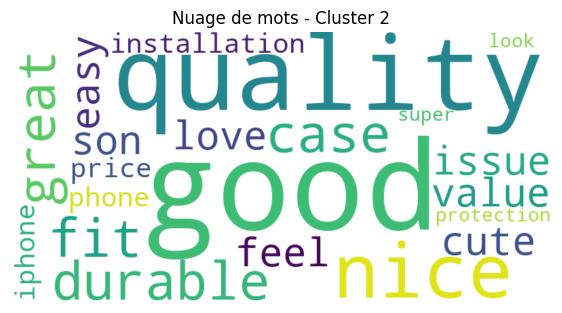

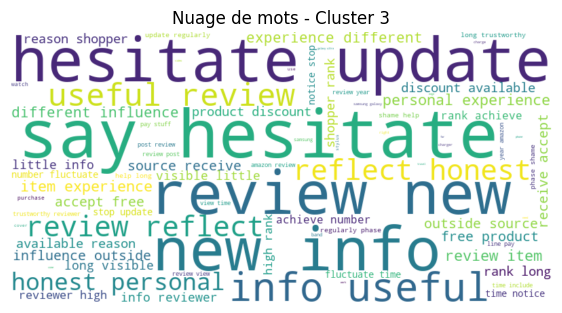

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filtrer les clusters pour exclure le cluster -1
filtered_clusters = {cluster_id: docs for cluster_id, docs in clusters.items() if cluster_id != -1}

# Générer et afficher les nuages de mots pour chaque cluster valide
for cluster_id, docs in filtered_clusters.items():
    text = " ".join(docs)  # Combiner tous les documents du cluster en une seule chaîne de caractères
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    # Afficher le nuage de mots
    plt.figure(figsize=(7, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Nuage de mots - Cluster {cluster_id}")
    plt.axis("off")
    plt.show()


### Clusters dans un espace réduit

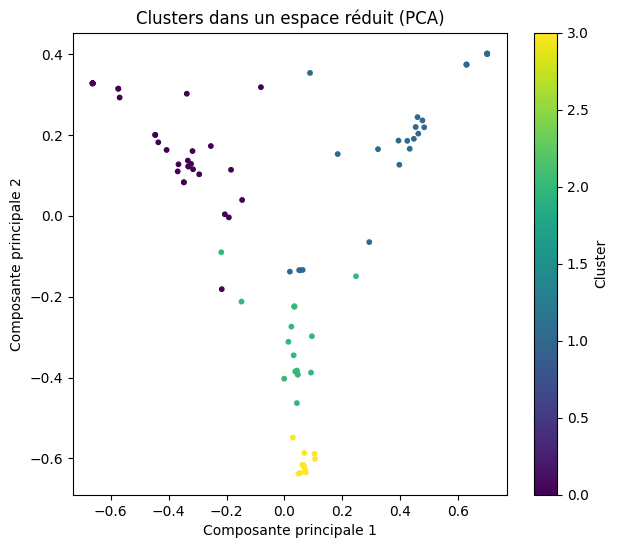

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Filtrer les points en excluant le cluster -1
valid_indices = dbscan_labels != -1
filtered_embeddings = tfidf_embeddings[valid_indices].toarray()
filtered_labels = dbscan_labels[valid_indices]

# Réduction des dimensions avec PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(filtered_embeddings)

# Visualisation
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=filtered_labels, cmap="viridis", s=10
)
plt.colorbar(scatter, label="Cluster")
plt.title("Clusters dans un espace réduit (PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()
